In [ ]:
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

# ขยาย stopwords เพิ่มเติม
default_stopwords = stopwords.words('english')
additional_stopwords = ['said', 'would','even','according','could','year',
                       'years','also','new','people','old','one','two','time',
                       'first','last','say','make','best','get','three','make',
                       'year old','told','made','like','take','many','set','number',
                       'month','week','well','back']
default_stopwords += additional_stopwords

# กำหนด regex สำหรับทำความสะอาดข้อความ
BAD_SYMBOLS_RE = re.compile("[^a-zA-Z,\d]")
REPLACE_IP_ADDRESS = re.compile(r'\b(?:[0-9]{1,3}\.){3}[0-9]{1,3}\b')
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')

def clean_text(text):
    def tokenize_text(text):
        return [w for s in sent_tokenize(text) for w in word_tokenize(s) if len(w) >= 3]

    def preprocessing_text(text):
        text = text.lower()
        text = text.replace('\n',' ').replace('\xa0',' ').replace('-',' ') \
                   .replace('ó','o').replace('ğ','g').replace('á','a').replace("'"," ")
        text = re.sub(r'\d+','', text)
        text = re.sub(r'http\S+', '', text)
        text = BAD_SYMBOLS_RE.sub(' ', text)
        text = REPLACE_IP_ADDRESS.sub('', text)
        text = REPLACE_BY_SPACE_RE.sub(' ', text)
        text = ' '.join(word for word in text.split() if len(word) > 3)
        return text

    def remove_special_characters(text, characters=string.punctuation.replace('-', '')):
        tokens = tokenize_text(text)
        pattern = re.compile('[{}]'.format(re.escape(characters + '0123456789')))
        return ' '.join(filter(None, [pattern.sub('', t) for t in tokens]))

    def lemm_text(text, lemm=WordNetLemmatizer()):
        tokens = tokenize_text(text)
        return ' '.join([lemm.lemmatize(t) for t in tokens])

    def remove_stopwords(text, stop_words=default_stopwords):
        tokens = [w for w in tokenize_text(text) if w not in stop_words]
        return ' '.join(tokens)
    
    text = text.strip(' ')  # ลบช่องว่างข้างหน้าและข้างหลัง
    text = preprocessing_text(text)
    text = remove_special_characters(text)  # ลบเครื่องหมายวรรคตอนและสัญลักษณ์
    text = lemm_text(text)  # Lemmatization
    text = remove_stopwords(text)  # ลบ stopwords

    return text

# โหลดข้อมูล
df = pd.read_csv('MN-DS-news-classification.csv')

# เลือกหมวดหมู่ที่สนใจ
selected_categories = [
    'arts, culture, entertainment and media',
    'economy, business and finance',
    'politics',
    'science and technology',
    'sport'
]
df = df[df['category_level_1'].isin(selected_categories)]

# รวมคอลัมน์ title และ content เข้าด้วยกัน
df['text'] = df[['title', 'content']].apply(lambda x: ' . '.join(x.astype(str)), axis=1)

# ทำความสะอาดข้อความ
df['text'] = df['text'].apply(clean_text)

# ฟังก์ชันสำหรับแปลงข้อความเป็น TF-IDF vectors
def get_tfidf(X):
    vectorizer = TfidfVectorizer(
        strip_accents='unicode',
        analyzer='word',
        ngram_range=(1,2),
        norm='l2',
        max_features=50000,
         sublinear_tf=True 
    )
    vectors = vectorizer.fit_transform(X)
    return vectors

# ฟังก์ชันสำหรับเข้ารหัส labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['category_level_1'])

# แปลงข้อความเป็น TF-IDF vectors
X_tfidf = get_tfidf(df['text'])

# แบ่งข้อมูลเป็น training และ testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# สร้างโมเดล OneVsRestClassifier กับ Logistic Regression และใช้ Class Weights
log_reg = LogisticRegression(solver='liblinear', class_weight='balanced')  # ใช้ 'balanced' เพื่อจัดการกับ class imbalance
model = OneVsRestClassifier(log_reg)

# ฝึกโมเดล
model.fit(X_train, y_train)

# ทำนายบน test set
y_pred = model.predict(X_test)

# ประเมินโมเดล
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

# สร้าง Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
labels = model.classes_
label_names = label_encoder.inverse_transform(labels)  # แปลงรหัสกลับเป็นชื่อคลาส

# แสดง Confusion Matrix ด้วย Seaborn
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names,
            yticklabels=label_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# แสดง Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))


Training Set Metrics:
Precision: 0.9724394443918694
Recall: 0.975015325670498
F1 Score: 0.973678195090135


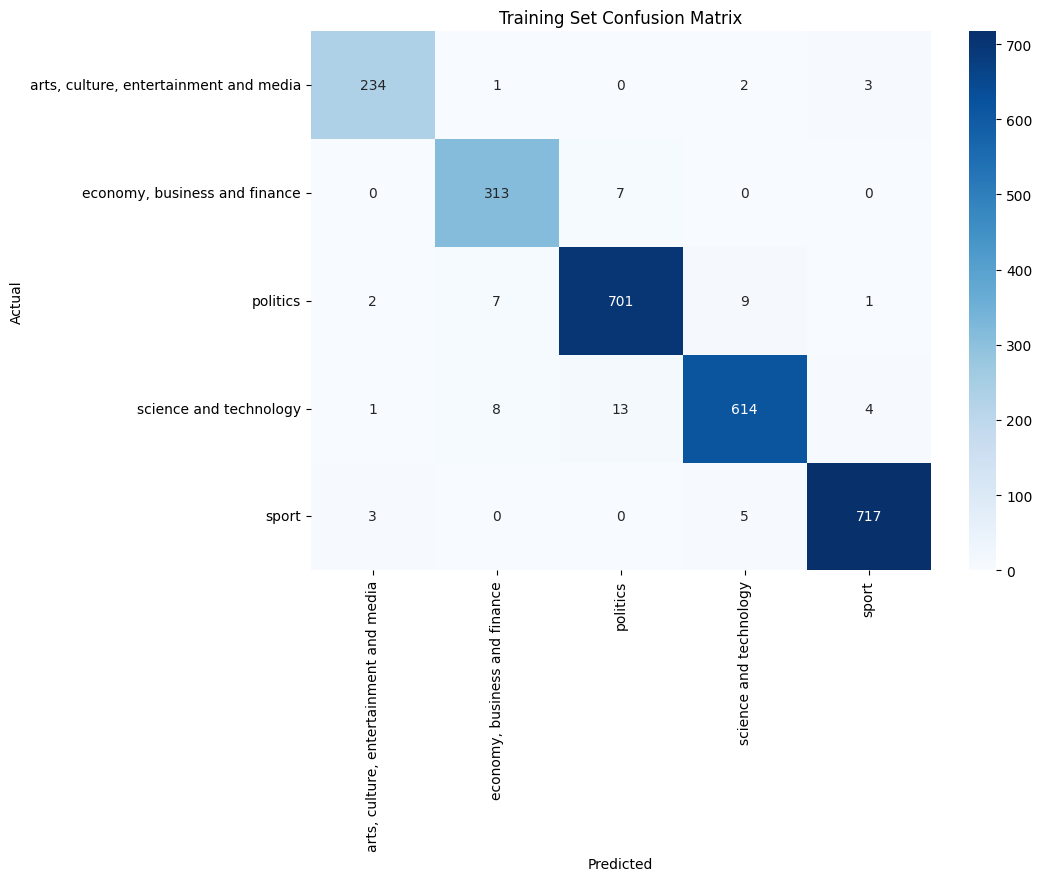


Training Set Classification Report:
                                         precision    recall  f1-score   support

arts, culture, entertainment and media       0.97      0.97      0.97       240
         economy, business and finance       0.95      0.98      0.96       320
                              politics       0.97      0.97      0.97       720
                science and technology       0.97      0.96      0.97       640
                                 sport       0.99      0.99      0.99       725

                              accuracy                           0.98      2645
                             macro avg       0.97      0.98      0.97      2645
                          weighted avg       0.98      0.98      0.98      2645


Comparison of Training and Testing Metrics:
Training Precision: 0.9724, Testing Precision: 0.9100
Training Recall: 0.9750, Testing Recall: 0.8913
Training F1 Score: 0.9737, Testing F1 Score: 0.8994


In [2]:
# Evaluate model on training set
y_train_pred = model.predict(X_train)

# Calculate metrics for training set
train_precision = precision_score(y_train, y_train_pred, average='macro')
train_recall = recall_score(y_train, y_train_pred, average='macro')
train_f1 = f1_score(y_train, y_train_pred, average='macro')

print('Training Set Metrics:')
print('Precision:', train_precision)
print('Recall:', train_recall)
print('F1 Score:', train_f1)

# Confusion Matrix for training set
train_cm = confusion_matrix(y_train, y_train_pred)

# Display Confusion Matrix for training set with Seaborn
plt.figure(figsize=(10,7))
sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names,
            yticklabels=label_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Training Set Confusion Matrix')
plt.show()

# Display Classification Report for training set
print("\nTraining Set Classification Report:\n", classification_report(y_train, y_train_pred, target_names=label_encoder.classes_))

# Compare training and testing metrics
print('\nComparison of Training and Testing Metrics:')
print(f'Training Precision: {train_precision:.4f}, Testing Precision: {precision:.4f}')
print(f'Training Recall: {train_recall:.4f}, Testing Recall: {recall:.4f}')
print(f'Training F1 Score: {train_f1:.4f}, Testing F1 Score: {f1:.4f}')
